In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import dateutil.parser as parser
from datetime import datetime, date, timedelta
import torch
import skorch
import scipy
import torch.nn as nn
import torch
import torch.nn.functional as F
import sys
from skorch.helper import DataFrameTransformer
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from skorch.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from skorch import NeuralNetRegressor
import pickle
import emoji
def identity_tokenizer(text):
    return text
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)

In [2]:
merged = pd.read_csv('mergedfullwithmoredates.csv')
from sklearn.model_selection import train_test_split  
mergedbig, mergedsmall = train_test_split(merged, test_size=0.15, random_state=0)
# mergedsmall.to_csv("mergedsmall.csv", index = False)
# mergedsmall = pd.read_csv('mergedsmall.csv')
merged = mergedsmall
merged = merged.dropna(subset=['Change1','Change2','Change3','Change4','Change5'])
merged = merged.reset_index(drop=True)
# Obtaining the tweet contents into a list
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
merged

,text,referenced_tweets,id,lang,Date,time,usedate,usedate1,usedate2,usedate3,...,Volume,Open,High,Low,Change,Change1,Change2,Change3,Change4,Change5
0,2020 is almost ended\n\nBRAND NEW SEALED FACTO...,1.317031e+18,1317047077411737601,en,2020-10-16,10:17:47,2020-10-16,2020-10-19,2020-10-20,2020-10-21,...,115393800.0,121.2800,121.5480,118.810,-2.260,-3.980,1.31,0.20,-1.7000,-1.3500
1,If you feel like Apple has no love for you by ...,NaN,1361013406829060106,en,2021-02-14,18:04:17,2021-02-16,2021-02-17,2021-02-18,2021-02-19,...,80576320.0,135.4900,136.0100,132.790,-2.300,-0.410,0.51,-0.37,-2.0100,2.1000
2,"📢NEW RIP IS LIVE📢\n\n2W1B 051 - iPhone, Capita...",NaN,1318150624626790402,en,2020-10-19,11:22:53,2020-10-19,2020-10-20,2020-10-21,2020-10-22,...,120639300.0,119.9600,120.4190,115.660,-3.980,1.310,0.20,-1.70,-1.3500,1.0400
3,#Apple has introduced a new #macOS version of ...,1.272588e+18,1272595399673630722,en,2020-06-15,18:22:41,2020-06-15,2020-06-16,2020-06-17,2020-06-18,...,138808920.0,83.3125,86.4200,83.145,2.435,0.155,-0.89,0.08,-1.2287,1.8825
4,Good Deal😍 #MacBookPro #AppleEvent #Apple\n\nN...,1.389114e+18,1389114470304305154,en,2021-05-03,07:07:52,2021-05-03,2021-05-04,2021-05-05,2021-05-06,...,75135100.0,132.0400,134.0700,131.830,0.500,-3.340,-1.10,1.85,-0.6400,-2.5600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501276,Foreign Exchange History: How it All Started?\...,1.316240e+18,1316312507431051264,en,2020-10-14,09:38:52,2020-10-14,2020-10-15,2020-10-16,2020-10-19,...,151062300.0,121.0000,123.0300,119.620,0.190,1.990,-2.26,-3.98,1.3100,0.2000
501277,"Tropicana Apple Juice, 10 oz., 24 Count\n\nSta...",NaN,1339593079318200320,en,2020-12-17,15:27:33,2020-12-17,2020-12-18,2020-12-21,2020-12-22,...,94359810.0,128.9000,129.5800,128.045,-0.200,-2.305,3.21,0.27,-1.2000,0.6500
501278,"""emotional conclusion to a dazzling series!""\n...",1.303296e+18,1307074421098766336,en,2020-09-18,21:50:00,2020-09-18,2020-09-21,2020-09-22,2020-09-23,...,287104900.0,110.4000,110.8800,106.090,-3.560,5.540,-0.87,-4.50,3.0500,3.8500
501279,3％超上昇した銘柄\n4434 サーバーワークス\n4625 アトミクス\n6777 ...,1.311853e+18,1311853293589725184,ja,2020-10-02,02:19:32,2020-10-02,2020-10-05,2020-10-06,2020-10-07,...,144712000.0,112.8900,115.3700,112.220,0.130,2.590,-2.54,0.46,-1.2800,1.6900


In [3]:
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Replace all emojis with text
    processed_tweet = emoji.demojize(processed_tweet)
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    
#     processed_tweet = re.sub(r'http\S+', '', processed_tweet)
    
    
#     processed_tweet = re.sub(r'co\S+', '', processed_tweet) 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
#     processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    

    
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweet = lemming(processed_tweet)
    
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)

In [4]:
y = merged[['Change','Change1','Change2','Change3','Change4','Change5','usedate','usedate1','usedate2','usedate3','usedate4','usedate5']]
# X = df3
# X = df2
# X = df2array
X = processed_tweets
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
with open("x_train_ah.txt", "rb") as fp:   # Unpickling
    x_train = pickle.load(fp)
y_train = pd.read_csv("y_train_ah.csv")
with open("x_test_ah.txt", "rb") as fp:   # Unpickling
    x_test = pickle.load(fp)
y_test = pd.read_csv("y_test_ah.csv")

In [4]:
print(len(x_train)+len(x_test))

3342224


In [5]:
y_train2 = y_train['Change2']
y_test2 = y_test['Change2']
y_train2 = y_train2.values.reshape(-1,1)
y_test2 = y_test2.values.reshape(-1,1)
y_train2 = y_train2.astype(np.float32)
y_test2 = y_test2.astype(np.float32)
in_dimension = 5765
hid_dimension = 160
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 5765
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=160,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 160)
        self.output = nn.Linear(160, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train2)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test2, y_pred, squared = False)
print("RMSE:", rmse)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.9898        4.0162  88.6056
      2        3.9728        3.9736  92.1938
      3        3.9138        3.9032  92.9110
      4        3.8737        3.8754  93.1764
      5        3.8461        3.8577  94.5334
      6        3.8258        3.8442  94.7520
      7        3.8102        3.8344  95.0848
      8        3.7982        3.8282  95.3725
      9        3.7878        3.8226  95.7430
     10        3.7767        3.8148  97.3155
     11        3.7666        3.8086  107.1002
     12        3.7560        3.8068  105.7502
     13        3.7458        3.7987  108.3607
     14        3.7331        3.7986  97.7162
     15        3.7216        3.7992  97.7900
     16        3.7095        3.7977  102.6131
     17        3.6975        3.7939  104.2614
     18        3.6869        3.7897  100.5697
     19        3.6752        3.7903  101.0327
     20        3.6630        3.7889  100.8389
RM

In [6]:
modelpreds = y_pred
y = y_test2
z = y_test['usedate2']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("")
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))


Profit: [719.85095]
Accuracy: 0.5546558704453441
Sum Invested: [510.29858]
Profitability: [1.4106466]


([<matplotlib.axis.XTick at 0x1ec93716880>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

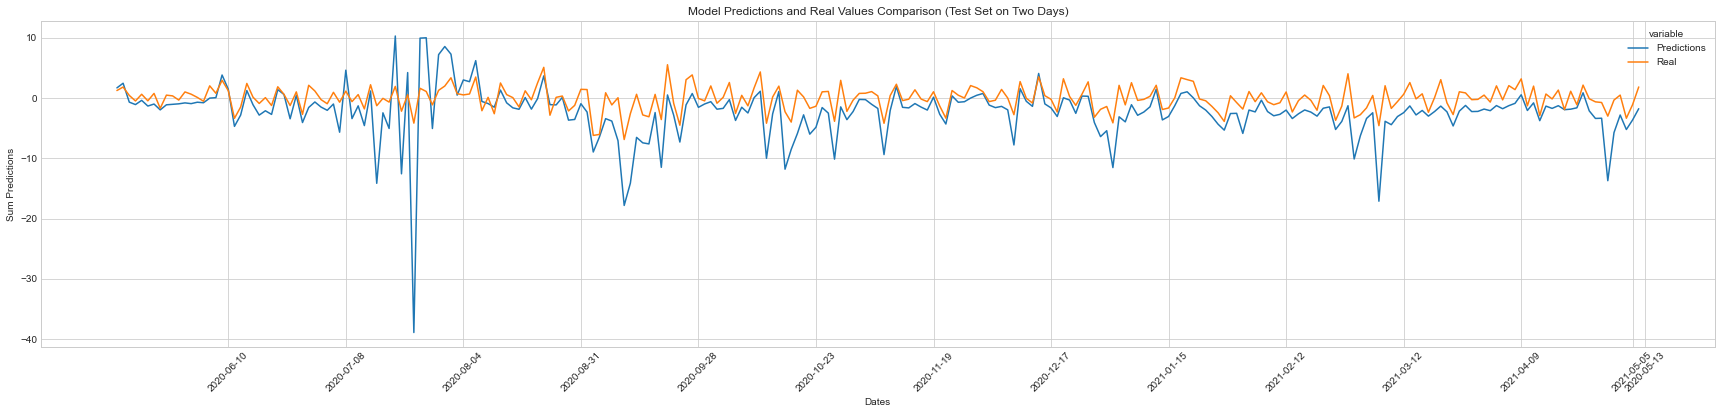

In [14]:
predsuml = [item for sublist in predsumlist for item in sublist]
realal = [item for sublist in realalist for item in sublist]

diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Model Predictions and Real Values Comparison (Test Set on Two Days)')
plt.xticks(['2020-05-13','2020-06-10', '2020-07-08', '2020-08-04', '2020-08-31',
 '2020-09-28', '2020-10-23', '2020-11-19', '2020-12-17', '2021-01-15',
 '2021-02-12', '2021-03-12', '2021-04-09','2021-05-05'],rotation=45)

In [7]:
merged = pd.read_csv('mergedfullholdout2.csv')
# ,'Change2','Change3','Change4','Change5'
merged = merged.dropna(subset=['Change2'])
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
# https://python.gotrained.com/scraping-tweets-sentiment-analysis/
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Replace all emojis with text
    processed_tweet = emoji.demojize(processed_tweet)
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    # Remove single characters from the start
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    processed_tweet = lemming(processed_tweet)
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)
x_holdout = processed_tweets
y_holdout = merged['Change2']
y_holdout_dates = merged['usedate2']
y_holdout = y_holdout.values.reshape(-1,1)
y_holdout = y_holdout.astype(np.float32)

In [9]:
with open("x_holdout.txt", "rb") as fp:   # Unpickling
    x_holdout = pickle.load(fp)
with open("y_holdout.txt", "rb") as fp:   # Unpickling
    y_holdout = pickle.load(fp)
with open("y_holdout_dates.txt", "rb") as fp:   # Unpickling
    y_holdout_dates = pickle.load(fp)

In [8]:
# y_holdout = y_holdout['Change2']
# y_holdout_dates = y_holdout_dates['usedate2']
# y_holdout = y_holdout.values.reshape(-1,1)
# y_holdout = y_holdout.astype(np.float32)
y_pred_holdout= pipe.predict(x_holdout)
rmse = mean_squared_error(y_holdout, y_pred_holdout, squared = False)
print("RMSE:", rmse)

RMSE: 1.3283619


In [9]:
modelpreds = y_pred_holdout
y = y_holdout
z = y_holdout_dates
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:

    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [-27.982206]
Accuracy: 0.46153846153846156
Sum Invested: [60.765934]
Profitability: [-0.46049166]


([<matplotlib.axis.XTick at 0x1ec379b0700>,
 [Text(0, 0, ''), Text(0, 0, '')])

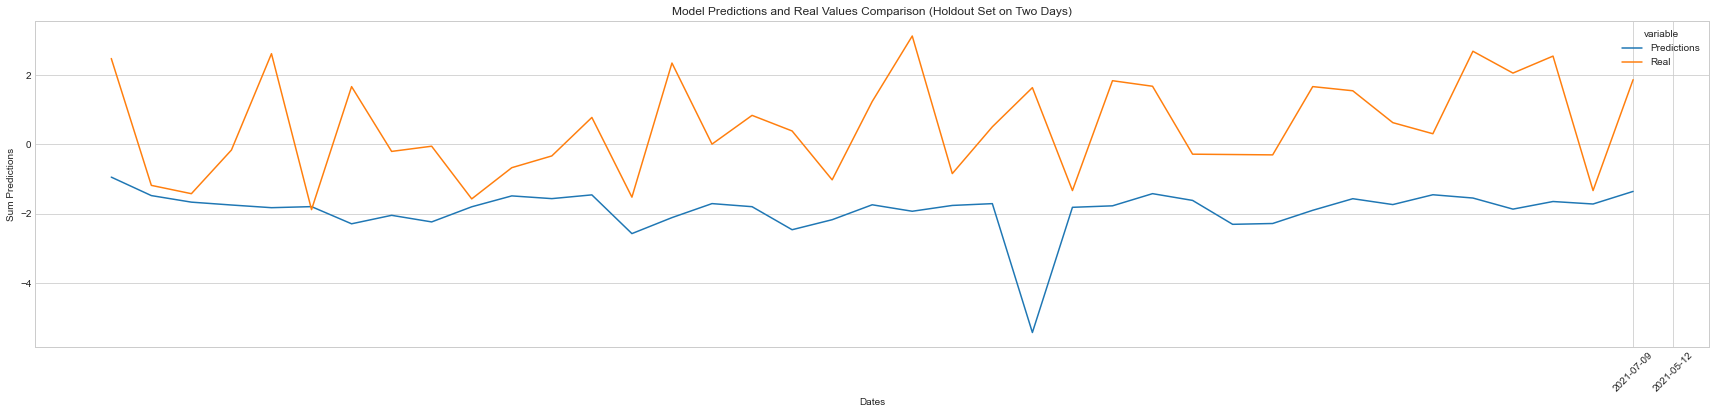

In [12]:
predsuml = [item for sublist in predsumlist for item in sublist]
realal = [item for sublist in realalist for item in sublist]

diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Model Predictions and Real Values Comparison (Holdout Set on Two Days)')
plt.xticks(['2021-05-12','2021-07-09'],rotation=45)

In [ ]:
merged = pd.read_csv('mergedfullwithmoredates.csv')
from sklearn.model_selection import train_test_split  
mergedbig, mergedsmall = train_test_split(merged, test_size=0.15, random_state=0)
# mergedsmall.to_csv("mergedsmall.csv", index = False)
# mergedsmall = pd.read_csv('mergedsmall.csv')
merged = mergedsmall
merged = merged.dropna(subset=['Change1','Change2','Change3','Change4','Change5'])
merged = merged.reset_index(drop=True)
# Obtaining the tweet contents into a list
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
merged
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Replace all emojis with text
    processed_tweet = emoji.demojize(processed_tweet)
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    
#     processed_tweet = re.sub(r'http\S+', '', processed_tweet)
    
    
#     processed_tweet = re.sub(r'co\S+', '', processed_tweet) 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
#     processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    

    
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweet = lemming(processed_tweet)
    
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)
    y = merged[['Change','Change1','Change2','Change3','Change4','Change5','usedate','usedate1','usedate2','usedate3','usedate4','usedate5']]
# X = df3
# X = df2
# X = df2array
X = processed_tweets
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train2 = y_train['Change2']
y_test2 = y_test['Change2']
y_train2 = y_train2.values.reshape(-1,1)
y_test2 = y_test2.values.reshape(-1,1)
y_train2 = y_train2.astype(np.float32)
y_test2 = y_test2.astype(np.float32)
in_dimension = 5765
hid_dimension = 160
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 5765
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=160,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 160)
        self.output = nn.Linear(160, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train2)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test2, y_pred, squared = False)
print("RMSE:", rmse)